In [120]:
# Load Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [122]:
# Load data 
df_train = pd.read_csv('data/train.csv')
df_train['created_date'] = pd.to_datetime(df_train['created_date'])

# Filter to training period: Aug 1, 2024 - Apr 30, 2025
df_train_filtered = df_train[
    (df_train['created_date'] >= '2024-08-01') & 
    (df_train['created_date'] <= '2025-04-30')
]
print(f"Training records: {len(df_train_filtered):,}")
print(f"Training date range: {df_train_filtered['created_date'].min()} to {df_train_filtered['created_date'].max()}")


Training records: 2,522,923
Training date range: 2024-08-01 00:00:00 to 2025-04-30 00:00:00


In [124]:
# Create daily call counts 
df_train_filtered['date'] = df_train_filtered['created_date'].dt.date
daily_calls_train = df_train_filtered.groupby('date').size().reset_index()
daily_calls_train.columns = ['date', 'total_calls']
daily_calls_train['date'] = pd.to_datetime(daily_calls_train['date'])
daily_calls_train = daily_calls_train.sort_values('date').reset_index(drop=True)

print(f"Training days: {len(daily_calls_train)}")
print(f"Average daily calls: {daily_calls_train['total_calls'].mean():.0f}")
print(f"Daily calls range: {daily_calls_train['total_calls'].min()} to {daily_calls_train['total_calls'].max()}")


Training days: 259
Average daily calls: 9741
Daily calls range: 3 to 15024


In [126]:
# Simple outlier capping
Q1 = daily_calls_train['total_calls'].quantile(0.25)
Q3 = daily_calls_train['total_calls'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
daily_calls_train['total_calls'] = np.clip(daily_calls_train['total_calls'], lower_bound, upper_bound)


In [148]:
# Load test.csv
df_test = pd.read_csv('data/test.csv')
df_test['created_date'] = pd.to_datetime(df_test['created_date'])
print(f"Test records: {len(df_test):,}")
print(f"Test date range: {df_test['created_date'].min()} to {df_test['created_date'].max()}")


Test records: 840,186
Test date range: 2025-05-01 00:00:02 to 2025-07-31 01:49:56


In [150]:
# Create test period date range for predictions
test_start_date = df_test['created_date'].min().date()
test_end_date = df_test['created_date'].max().date()
test_dates = pd.date_range(test_start_date, test_end_date, freq='D')
print(f"Prediction period: {test_start_date} to {test_end_date}")
print(f"Days to predict: {len(test_dates)}")

Prediction period: 2025-05-01 to 2025-07-31
Days to predict: 92


In [132]:
#Feature Engineering 
def add_features(df):
    """Add time-based features to a dataframe with date column"""
    df = df.copy()
    df['day_of_week'] = df['date'].dt.dayofweek  
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)
    df['is_monday'] = (df['date'].dt.dayofweek == 0).astype(int)
    df['is_friday'] = (df['date'].dt.dayofweek == 4).astype(int)
    
    
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    # Season features
    df['season'] = df['month'].map({12: 0, 1: 0, 2: 0,  # Winter
                                    3: 1, 4: 1, 5: 1,   # Spring
                                    6: 2, 7: 2, 8: 2,   # Summer
                                    9: 3, 10: 3, 11: 3}) # Fall
    
    # Cyclical encoding for day of week 
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    return df

In [134]:
# Add features to training data
daily_calls_train = add_features(daily_calls_train)

# Add lag features 
daily_calls_train['calls_lag1'] = daily_calls_train['total_calls'].shift(1)
daily_calls_train['calls_lag7'] = daily_calls_train['total_calls'].shift(7)
daily_calls_train['calls_rolling_7'] = daily_calls_train['total_calls'].rolling(window=7, min_periods=1).mean()
daily_calls_train['calls_rolling_30'] = daily_calls_train['total_calls'].rolling(window=30, min_periods=1).mean()

# Fill NaN values
daily_calls_train['calls_lag1'] = daily_calls_train['calls_lag1'].fillna(daily_calls_train['total_calls'].mean())
daily_calls_train['calls_lag7'] = daily_calls_train['calls_lag7'].fillna(daily_calls_train['total_calls'].mean())

# Define features
feature_cols = ['day_of_week', 'month', 'day_of_month', 'is_weekend', 'is_monday', 'is_friday',
                'days_since_start', 'season', 'day_sin', 'day_cos',
                'calls_lag1', 'calls_lag7', 'calls_rolling_7', 'calls_rolling_30']


In [136]:
# Split for validation 
train_data = daily_calls_train[:-30].copy()
val_data = daily_calls_train[-30:].copy()

print(f"Model training days: {len(train_data)}")
print(f"Validation days: {len(val_data)}")

# Train Random Forest model
model = RandomForestRegressor(
    n_estimators=300,  
    max_depth=20,      
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(train_data[feature_cols], train_data['total_calls'])


Model training days: 229
Validation days: 30


RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [152]:
# Validate
val_pred = model.predict(val_data[feature_cols])
val_pred = np.maximum(val_pred, 0)  

# Calculate metrics
rmse = np.sqrt(mean_squared_error(val_data['total_calls'], val_pred))
mape = mean_absolute_percentage_error(val_data['total_calls'], val_pred)

print(f"\nVALIDATION RESULTS")
print(f"RMSE: {rmse:.0f}")
print(f"MAPE: {mape:.3f} ({mape*100:.1f}%)")



VALIDATION RESULTS
RMSE: 684
MAPE: 0.057 (5.7%)


In [157]:
# Initialize lag features for test period
predictions = []
last_7_calls = daily_calls_train['total_calls'].tail(7).tolist()

for i, date in enumerate(test_dates):
    
    if i == 0:
        lag1 = daily_calls_train['total_calls'].iloc[-1]
        lag7 = daily_calls_train['total_calls'].iloc[-7] if len(daily_calls_train) >= 7 else daily_calls_train['total_calls'].mean()
    else:
        lag1 = predictions[i-1]
        lag7 = predictions[i-7] if i >= 7 else last_7_calls[i % 7]
    
    
    if i == 0:
        rolling_7 = daily_calls_train['calls_rolling_7'].iloc[-1]
        rolling_30 = daily_calls_train['calls_rolling_30'].iloc[-1]
    else:
        recent_calls = last_7_calls + predictions
        rolling_7 = np.mean(recent_calls[-(min(7, len(recent_calls))):])
        rolling_30 = np.mean(recent_calls[-(min(30, len(recent_calls))):])
    
  
    test_row = test_df[test_df['date'] == date].copy()
    test_row['calls_lag1'] = lag1
    test_row['calls_lag7'] = lag7
    test_row['calls_rolling_7'] = rolling_7
    test_row['calls_rolling_30'] = rolling_30
    
    # Make prediction
    pred = model.predict(test_row[feature_cols])[0]
    pred = max(0, int(round(pred)))  # Ensure non-negative integer
    predictions.append(pred)


In [159]:
# Create submission
submission_df = pd.DataFrame({
    'date': test_dates,
    'predicted_calls': predictions
})
submission_df.to_csv('submission.csv', index=False)


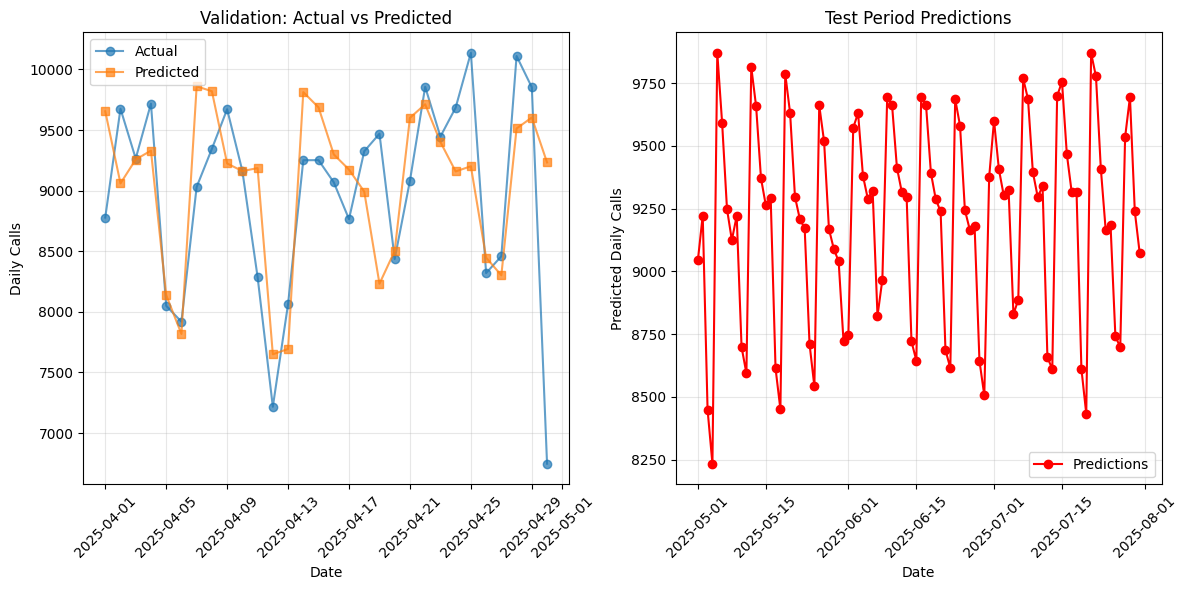


=== FINAL SUMMARY ===
Training period: 2024-08-01 to 2025-04-30
Prediction period: 2025-05-01 to 2025-07-31
Model validation RMSE: 684
Model validation MAPE: 0.057 (5.7%)
Average training calls/day: 9672
Average predicted calls/day: 9205
Files created: submission.csv, validation_plot.png

✅ Model training and prediction complete!


In [161]:
# Create validation plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(val_data['date'], val_data['total_calls'], 'o-', label='Actual', alpha=0.7)
plt.plot(val_data['date'], val_pred, 's-', label='Predicted', alpha=0.7)
plt.title('Validation: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Calls')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(submission_df['date'], predictions, 'o-', label='Predictions', color='red')
plt.title('Test Period Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Daily Calls')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# summary
print(f"\nFINAL SUMMARY ")
print(f"Training period: {daily_calls_train['date'].min().date()} to {daily_calls_train['date'].max().date()}")
print(f"Prediction period: {test_df['date'].min().date()} to {test_df['date'].max().date()}")
print(f"Model validation RMSE: {rmse:.0f}")
print(f"Model validation MAPE: {mape:.3f} ({mape*100:.1f}%)")
print(f"Average training calls/day: {daily_calls_train['total_calls'].mean():.0f}")
print(f"Average predicted calls/day: {np.mean(predictions):.0f}")
print(f"Files created: submission.csv, validation_plot.png")
print("\n✅ Model training and prediction complete!")

In [171]:
# Load test data 
df_test = pd.read_csv('data/test.csv')
df_test['created_date'] = pd.to_datetime(df_test['created_date'])
df_test['date'] = df_test['created_date'].dt.date


In [173]:
# Get daily actual calls
daily_actual = df_test.groupby('date').size().reset_index()
daily_actual.columns = ['date', 'actual_calls']
daily_actual['date'] = pd.to_datetime(daily_actual['date'])



In [177]:
# Load predictions
predictions = pd.read_csv('submission.csv')
predictions['date'] = pd.to_datetime(predictions['date'])
predictions.columns = ['date', 'predicted_calls']


In [179]:
# Merge actual and predicted
anomalies = pd.merge(daily_actual, predictions, on='date')

# Calculate anomaly score 
anomalies['anomaly_score'] = ((anomalies['actual_calls'] - anomalies['predicted_calls']) / 
                             anomalies['predicted_calls']) * 100


In [181]:
# Get top 5 spikes and top 5 dips
spikes = anomalies.nlargest(5, 'anomaly_score')
dips = anomalies.nsmallest(5, 'anomaly_score')
top_anomalies = pd.concat([spikes, dips])


In [183]:
# Add simple notes
def add_notes(row):
    date = row['date']
    if date.dayofweek == 0:  
        return "Monday spike"
    elif date.dayofweek == 6:  
        return "Weekend dip"
    elif date.month == 7 and date.day == 4:
        return "July 4th Holiday"
    elif date.month == 5 and date.day == 27:
        return "Memorial Day"
    elif row['anomaly_score'] > 0:
        return "Unusual spike"
    else:
        return "Unusual dip"

top_anomalies['note'] = top_anomalies.apply(add_notes, axis=1)


In [185]:
# Create output file
output = top_anomalies[['date', 'actual_calls', 'predicted_calls', 'anomaly_score', 'note']].copy()
output.columns = ['Date', 'Actual', 'Expected', 'Anomaly_Score', 'Note']
output['Date'] = output['Date'].dt.strftime('%Y-%m-%d')
output['Anomaly_Score'] = output['Anomaly_Score'].round(1)

# Save
output.to_csv('anomalies.csv', index=False)
print(f"✅ Created anomalies.csv with {len(output)} anomalies")
print(output.head())

✅ Created anomalies.csv with 10 anomalies
          Date  Actual  Expected  Anomaly_Score           Note
65  2025-07-05   10791      8829           22.2  Unusual spike
10  2025-05-11   10425      8594           21.3    Weekend dip
16  2025-05-17   10327      8614           19.9  Unusual spike
17  2025-05-18   10101      8451           19.5    Weekend dip
54  2025-06-24   11451      9581           19.5  Unusual spike
